In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



In [2]:


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorf

In [3]:
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = []
for i in range (6):
    idx.extend(np.where(X_train.targets == i)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [4]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = []
for i in range (6):
    idx.extend(np.where(X_test.targets == i)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [5]:
n_qubits = 2
num_epoch = 40

In [6]:
dev = qml.device('default.qubit.autograd', wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

In [8]:
@qml.qnode(dev, interface='torch',diff_method='best')
def q_net(q_in):
        
        H_layer(n_qubits)   
        
        RY_layer(q_in)      
       

        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [9]:
# Quantum activation funciton
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, q_in):
     
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))

            return (q_out)


In [10]:
# # Hybrid QCNN model with fc2 layer followed by quantum activation function 
class QCNN(nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size = 2)
        self.pool2 = nn.AvgPool2d(kernel_size = 2)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.quantum = Quantumnet()
        self.fc3 = nn.Linear(2, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.quantum(x)
        x = self.fc3(x)
        return x

In [11]:
# CNN model with fc2 layer followed by sigmoid function 
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.fc3 = nn.Linear(2, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)
        return x

In [12]:
# CNN model with fc2 layer followed by tanh function 
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.fc3 = nn.Linear(2, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

In [13]:
def train(model,opimizer,loss_func,train_loader):
    model.train()

    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())

    return sum(total_loss)/len(total_loss)


In [14]:
def validation(model,test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = loss_func(output, target)
            total_loss.append(loss.item())
    loss = sum(total_loss) / len(total_loss)
    acc = correct / len(test_loader) * 100

    return loss, acc

## Performance evaluation of hybrid QCNN model with quantum activation function

In [15]:

model = QCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train_loss_list1 = []
test_loss_list1 = []
acc_list1 = []
for epoch in range(num_epoch):
    train_loss = train(model,optimizer,loss_func,train_loader)
    #print(train_loss )
    train_loss_list1.append(train_loss)
    test_loss, acc = validation(model,test_loader)
   # print(acc)
    acc_list1.append(acc)
    test_loss_list1.append(test_loss)
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / num_epoch, train_loss,acc))
    

Training [2%]	train_Loss: 1.6888	test_acc: 60.3%
Training [5%]	train_Loss: 1.4029	test_acc: 66.3%
Training [8%]	train_Loss: 1.2144	test_acc: 66.7%
Training [10%]	train_Loss: 1.0436	test_acc: 70.7%
Training [12%]	train_Loss: 0.9336	test_acc: 71.0%
Training [15%]	train_Loss: 0.8576	test_acc: 74.0%
Training [18%]	train_Loss: 0.7770	test_acc: 75.7%
Training [20%]	train_Loss: 0.7193	test_acc: 80.0%
Training [22%]	train_Loss: 0.6804	test_acc: 79.7%
Training [25%]	train_Loss: 0.6449	test_acc: 82.0%
Training [28%]	train_Loss: 0.6173	test_acc: 82.3%
Training [30%]	train_Loss: 0.5826	test_acc: 81.0%
Training [32%]	train_Loss: 0.5525	test_acc: 85.0%
Training [35%]	train_Loss: 0.5347	test_acc: 81.3%
Training [38%]	train_Loss: 0.4963	test_acc: 81.7%
Training [40%]	train_Loss: 0.4838	test_acc: 80.0%
Training [42%]	train_Loss: 0.4734	test_acc: 82.7%
Training [45%]	train_Loss: 0.4522	test_acc: 80.0%
Training [48%]	train_Loss: 0.4558	test_acc: 81.0%
Training [50%]	train_Loss: 0.4452	test_acc: 80.3%
Tra

## Performance evaluation of CNN model with sigmoild activation funciton

In [16]:

model = CNN1()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train_loss_list2 = []
test_loss_list2 = []
acc_list2 = []
for epoch in range(num_epoch):
    train_loss = train(model,optimizer,loss_func,train_loader)
    #print(train_loss )
    train_loss_list2.append(train_loss)
    test_loss, acc = validation(model,test_loader)
   # print(acc)
    acc_list2.append(acc)
    test_loss_list2.append(test_loss)
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / num_epoch, train_loss,acc))
    

Training [2%]	train_Loss: 1.7758	test_acc: 29.0%
Training [5%]	train_Loss: 1.5944	test_acc: 48.7%
Training [8%]	train_Loss: 1.4806	test_acc: 48.0%
Training [10%]	train_Loss: 1.4064	test_acc: 49.3%
Training [12%]	train_Loss: 1.3434	test_acc: 48.7%
Training [15%]	train_Loss: 1.2829	test_acc: 49.0%
Training [18%]	train_Loss: 1.2247	test_acc: 47.3%
Training [20%]	train_Loss: 1.1728	test_acc: 48.3%
Training [22%]	train_Loss: 1.1454	test_acc: 47.7%
Training [25%]	train_Loss: 1.1017	test_acc: 49.0%
Training [28%]	train_Loss: 1.0640	test_acc: 48.7%
Training [30%]	train_Loss: 1.0375	test_acc: 51.0%
Training [32%]	train_Loss: 1.0128	test_acc: 56.0%
Training [35%]	train_Loss: 1.0029	test_acc: 52.7%
Training [38%]	train_Loss: 0.9643	test_acc: 54.0%
Training [40%]	train_Loss: 0.9345	test_acc: 61.0%
Training [42%]	train_Loss: 0.9030	test_acc: 66.3%
Training [45%]	train_Loss: 0.8782	test_acc: 65.3%
Training [48%]	train_Loss: 0.8429	test_acc: 65.3%
Training [50%]	train_Loss: 0.8116	test_acc: 64.7%
Tra

##  Performance evaluation of CNN model with tanh activation funciton

In [17]:

model = CNN2()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train_loss_list3 = []
test_loss_list3 = []
acc_list3 = []
for epoch in range(num_epoch):
    train_loss = train(model,optimizer,loss_func,train_loader)
    #print(train_loss )
    train_loss_list3.append(train_loss)
    test_loss, acc = validation(model,test_loader)
   # print(acc)
    acc_list3.append(acc)
    test_loss_list3.append(test_loss)
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / num_epoch, train_loss,acc))
    

Training [2%]	train_Loss: 1.6552	test_acc: 44.3%
Training [5%]	train_Loss: 1.3905	test_acc: 48.0%
Training [8%]	train_Loss: 1.2739	test_acc: 53.0%
Training [10%]	train_Loss: 1.1622	test_acc: 54.3%
Training [12%]	train_Loss: 1.1186	test_acc: 56.7%
Training [15%]	train_Loss: 1.0284	test_acc: 57.3%
Training [18%]	train_Loss: 0.9525	test_acc: 64.7%
Training [20%]	train_Loss: 0.8967	test_acc: 67.0%
Training [22%]	train_Loss: 0.8231	test_acc: 65.0%
Training [25%]	train_Loss: 0.7975	test_acc: 63.3%
Training [28%]	train_Loss: 0.7600	test_acc: 63.3%
Training [30%]	train_Loss: 0.7266	test_acc: 67.0%
Training [32%]	train_Loss: 0.7382	test_acc: 65.0%
Training [35%]	train_Loss: 0.6971	test_acc: 64.7%
Training [38%]	train_Loss: 0.6673	test_acc: 66.0%
Training [40%]	train_Loss: 0.6530	test_acc: 67.0%
Training [42%]	train_Loss: 0.6389	test_acc: 67.3%
Training [45%]	train_Loss: 0.6540	test_acc: 65.0%
Training [48%]	train_Loss: 0.6186	test_acc: 69.0%
Training [50%]	train_Loss: 0.5961	test_acc: 67.0%
Tra

## Plot loss and accurcy curves

Text(0, 0.5, 'Loss')

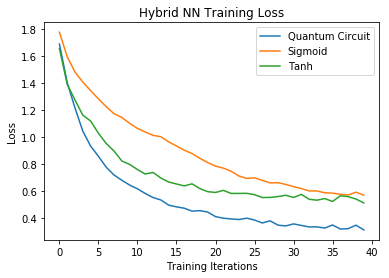

In [18]:
plt.plot(train_loss_list1,label='Quantum Circuit')
plt.plot(train_loss_list2,label='Sigmoid')
plt.plot(train_loss_list3,label='Tanh')

plt.legend()
plt.title('Hybrid NN Training Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

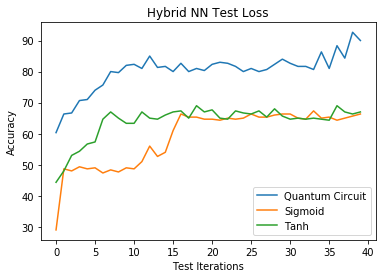

In [19]:
plt.plot(acc_list1,label='Quantum Circuit')
plt.plot(acc_list2,label='Sigmoid')
plt.plot(acc_list3,label='Tanh')

plt.legend()
plt.title('Hybrid NN Test Loss')
plt.xlabel('Test Iterations')
plt.ylabel('Accuracy')
